### Decision Tree Model Tuning for 2016 - 2020 Data (imports)

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import modelinghelper as helper

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from adspy_shared_utilities import plot_feature_importances
from adspy_shared_utilities import plot_decision_tree
import matplotlib.pyplot as plt

import joblib
import os
from datetime import datetime

# supress future warnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [18]:
#set up random seed
rng = 42

# set up folder to save results
output_path = 'import_run8_TargetEncoding_gridsearchCV'
dataset = 'import'

if not os.path.exists(output_path):
    os.makedirs(output_path)
else:
    print("Folder already exists")

# file name
prefix = f'{output_path}/{dataset}'

In [3]:
# read in data
p = '../data/'
input_name = 'cleaned.csv'

df = pd.read_csv(f'{p}{input_name}')

In [4]:
df['ship_date_mm'] = df['ship_date_mm'].astype(str)

In [5]:
df.describe()

,control_number,qty,value,qty_new,ship_date_yyyy
count,1.890132e+06,1.890132e+06,1.890132e+06,1.890132e+06,1.890132e+06
mean,2.018142e+09,1.955213e+06,9.658016e+03,1.954949e+06,2.017558e+03
std,1.263350e+06,2.644078e+08,9.355053e+05,2.644078e+08,1.279415e+00
min,2.014539e+09,-1.000000e+00,0.000000e+00,-1.000000e+00,2.016000e+03
25%,2.016978e+09,1.500000e+00,5.100000e+01,1.000000e+00,2.016000e+03
50%,2.017984e+09,9.000000e+00,3.180000e+02,8.000000e+00,2.017000e+03
75%,2.019505e+09,9.300000e+01,2.104000e+03,8.600000e+01,2.019000e+03
max,2.020755e+09,9.990708e+10,1.242236e+09,9.990708e+10,2.020000e+03


In [6]:
non_feature_cols = ['control_number', 'disp_date', 'i_e', 'ship_date', 
                    'cartons', 'qty', 'unit', 'specific_generic_name',
                    'genus', 'species', 'wildlf_cat', 
                    'disp_date_yyyy', 'disp_date_mm', 'disp_ship_date']

target = ['act', 'dp_cd']

feature_cols = ['species_code', 'wildlf_desc', 'wildlf_cat',
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 
                 'value', 'ship_date_mm']

import_df = helper.df_filtering(df, i_e = 'I', f_cols = feature_cols)
# import: 1590505 rows × 11 columns
# export: 299340 rows × 11 columns

#### Modeling Pipeline

In [7]:
X_train, X_test, y_train, y_test = helper.data_split(import_df)

#### Decision Tree

In [8]:
clf = DecisionTreeClassifier(random_state=rng)
dt_params={
    'clf__class_weight':[None,
                         'balanced', 
                         #{0:100, 1:1}, 
                         {0:50, 1:1}],
    'clf__max_depth': [2,3,4,5,6,7,8,9,10, None]
}

%time dt_pipe = helper.gridsearch_pipeline(X_train, y_train, clf, dt_params) 
dt_pipe

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END clf__class_weight=None, clf__max_depth=2;, score=0.300 total time=  10.2s
[CV 2/5] END clf__class_weight=None, clf__max_depth=2;, score=0.303 total time=  10.3s
[CV 3/5] END clf__class_weight=None, clf__max_depth=2;, score=0.303 total time=  10.4s
[CV 4/5] END clf__class_weight=None, clf__max_depth=2;, score=0.231 total time=  10.2s
[CV 5/5] END clf__class_weight=None, clf__max_depth=2;, score=0.222 total time=  10.2s
[CV 1/5] END clf__class_weight=None, clf__max_depth=3;, score=0.420 total time=  10.5s
[CV 2/5] END clf__class_weight=None, clf__max_depth=3;, score=0.431 total time=  10.4s
[CV 3/5] END clf__class_weight=None, clf__max_depth=3;, score=0.428 total time=  10.7s
[CV 4/5] END clf__class_weight=None, clf__max_depth=3;, score=0.392 total time=  10.5s
[CV 5/5] END clf__class_weight=None, clf__max_depth=3;, score=0.386 total time=  10.3s
[CV 1/5] END clf__class_weight=None, clf__max_depth=4;, score=0.410 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('targetEncoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['species_code',
                                                                          'wildlf_desc',
                                                                          'wildlf_cat',
                                                                          'ctry_org',
                                                                          'ctry_ie',
                                                                          'purp',
                                                                          'src',
                                                                          'trans_mode',
                                                                          'pt_cd',
                                                                          'ship_date_mm'])])),
                                       ('standardScaler', StandardScaler()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'clf__class_weight': [None, 'balanced', {0: 50, 1: 1}],
                         'clf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None]},
             scoring='recall', verbose=3)

In [19]:
joblib.dump(dt_pipe, f'{prefix}_dt_pipe.joblib')

['import_run8_TargetEncoding_gridsearchCV/import_dt_pipe.joblib']

Decision Tree (best model)
 [[  5229   1282]
 [ 66830 324286]]


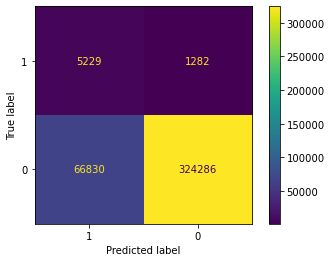

In [13]:
outputs = True
dt_predicted = dt_pipe.predict(X_test)
confusion = confusion_matrix(y_test, dt_predicted, labels = [1,0])
if outputs:
    print('Decision Tree (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()

#### Random Forest

In [12]:
clf = RandomForestClassifier(random_state=rng)
rf_params={
    'clf__n_estimators':[4,6,8,10, 20, 30, 50, 100],
    'clf__max_depth': [None, 3, 4, 5,7,8,9, 10],
    'clf__class_weight':['balanced', None]
}

%time rf_pipe = helper.gridsearch_pipeline(X_train, y_train, clf, rf_params) 
rf_pipe

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.553 total time=  12.9s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.571 total time=  12.7s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.560 total time=  13.1s
[CV 4/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.567 total time=  13.0s
[CV 5/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.557 total time=  12.9s
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=6;, score=0.571 total time=  14.5s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=6;, score=0.586 total time=  14.3s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=6;, score=0.574 total time=  14.2s
[CV 4/5] END clf_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('targetEncoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['species_code',
                                                                          'wildlf_desc',
                                                                          'wildlf_cat',
                                                                          'ctry_org',
                                                                          'ctry_ie',
                                                                          'purp',
                                                                          'src',
                                                                          'trans_mode',
                                                                          'pt_cd',
                                                                          'ship_date_mm'])])),
                                       ('standardScaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__class_weight': ['balanced', None],
                         'clf__max_depth': [None, 3, 4, 5, 7, 8, 9, 10],
                         'clf__n_estimators': [4, 6, 8, 10, 20, 30, 50, 100]},
             scoring='recall', verbose=3)

In [17]:
clf = RandomForestClassifier(random_state=rng)
rf_params_2={
    'clf__n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'clf__max_depth': [None, 5,7,8,9, 10],
    'clf__class_weight':['balanced']
}

%time rf_pipe_2 = helper.gridsearch_pipeline(X_train, y_train, clf, rf_params_2) 
rf_pipe_2

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=10;, score=0.579 total time=  19.2s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=10;, score=0.595 total time=  19.6s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=10;, score=0.590 total time=  19.5s
[CV 4/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=10;, score=0.603 total time=  19.0s
[CV 5/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=10;, score=0.584 total time=  19.2s
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=20;, score=0.595 total time=  28.3s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=20;, score=0.610 total time=  28.8s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=20;, score=0.602 total time=  29.1s
[CV 4/5] E

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('targetEncoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['species_code',
                                                                          'wildlf_desc',
                                                                          'wildlf_cat',
                                                                          'ctry_org',
                                                                          'ctry_ie',
                                                                          'purp',
                                                                          'src',
                                                                          'trans_mode',
                                                                          'pt_cd',
                                                                          'ship_date_mm'])])),
                                       ('standardScaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__class_weight': ['balanced'],
                         'clf__max_depth': [None, 5, 7, 8, 9, 10],
                         'clf__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80,
                                               90, 100]},
             scoring='recall', verbose=3)

In [20]:
joblib.dump(rf_pipe, f'{prefix}_rf_pipe.joblib')

['import_run8_TargetEncoding_gridsearchCV/import_rf_pipe.joblib']

In [21]:
joblib.dump(rf_pipe_2, f'{prefix}_rf_pipe_2.joblib')

['import_run8_TargetEncoding_gridsearchCV/import_rf_pipe_2.joblib']

Decision Tree (best model)
 [[  5229   1282]
 [ 66830 324286]]


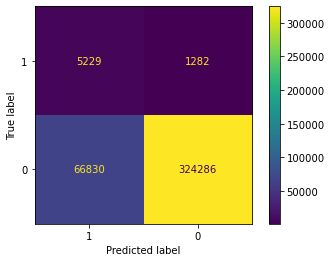

In [22]:
outputs = True
dt_predicted = dt_pipe.predict(X_test)
confusion = confusion_matrix(y_test, dt_predicted, labels = [1,0])
if outputs:
    print('Decision Tree (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()

In [49]:
print(classification_report(y_test, dt_predicted))

              precision    recall  f1-score   support

           0       1.00      0.83      0.90    391116
           1       0.07      0.80      0.13      6511

    accuracy                           0.83    397627
   macro avg       0.53      0.82      0.52    397627
weighted avg       0.98      0.83      0.89    397627



Random Forest (best model)
 [[  5201   1310]
 [ 29375 361741]]


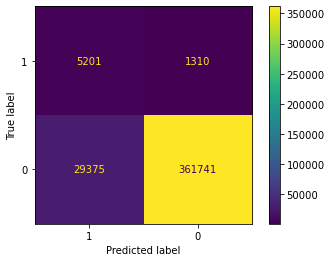

In [23]:
outputs = True
rf_predicted = rf_pipe.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted, labels = [1,0])
if outputs:
    print('Random Forest (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()

In [50]:
print(classification_report(y_test, rf_predicted))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96    391116
           1       0.15      0.80      0.25      6511

    accuracy                           0.92    397627
   macro avg       0.57      0.86      0.61    397627
weighted avg       0.98      0.92      0.95    397627



Random Forest (best model)
 [[  5201   1310]
 [ 29375 361741]]


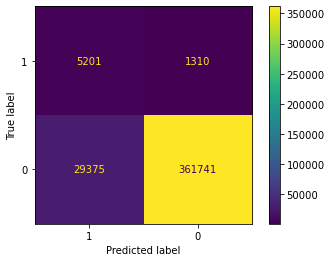

In [69]:
outputs = True
rf_predicted_2 = rf_pipe_2.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted_2, labels = [1,0])
if outputs:
    print('Random Forest (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()

In [35]:
rf_pipe_2.best_estimator_.named_steps['clf'].feature_importances_

array([0.37066665, 0.10239282, 0.00887256, 0.19961692, 0.05429489,
       0.09657009, 0.02579527, 0.0705364 , 0.0466514 , 0.00112239,
       0.0234806 ])

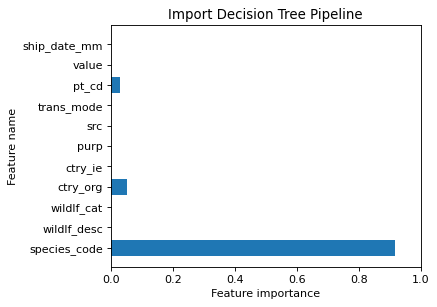

Feature importances: [0.        0.        0.0290232 0.        0.        0.        0.
 0.053944  0.        0.        0.9170328]


In [66]:
plt.figure(figsize=(5,4), dpi=80)
plot_feature_importances(dt_pipe.best_estimator_.named_steps['clf'], feature_cols)
plt.title('Import Decision Tree Pipeline')
plt.xlim(0, 1)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(dt_pipe.best_estimator_.named_steps['clf'].feature_importances_[::-1]))

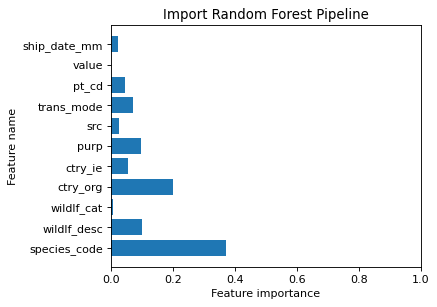

Feature importances: [0.0234806  0.00112239 0.0466514  0.0705364  0.02579527 0.09657009
 0.05429489 0.19961692 0.00887256 0.10239282 0.37066665]


In [67]:
plt.figure(figsize=(5,4), dpi=80)
plot_feature_importances(rf_pipe_2.best_estimator_.named_steps['clf'], feature_cols)
plt.title('Import Random Forest Pipeline')
plt.xlim(0, 1)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(rf_pipe_2.best_estimator_.named_steps['clf'].feature_importances_[::-1]))

[Text(0.5, 0.875, 'X[0] <= 0.003\ngini = 0.5\nsamples = 1192878\nvalue = [596439.0, 596439.0]'),
 Text(0.25, 0.625, 'X[0] <= -0.16\ngini = 0.317\nsamples = 1014519\nvalue = [513604.684, 126085.226]'),
 Text(0.125, 0.375, 'X[3] <= 4.292\ngini = 0.169\nsamples = 722741\nvalue = [366759.768, 37620.973]'),
 Text(0.0625, 0.125, 'gini = 0.147\nsamples = 718262\nvalue = [364580.586, 31757.964]'),
 Text(0.1875, 0.125, 'gini = 0.395\nsamples = 4479\nvalue = [2179.182, 5863.009]'),
 Text(0.375, 0.375, 'X[8] <= 0.525\ngini = 0.469\nsamples = 291778\nvalue = [146844.916, 88464.253]'),
 Text(0.3125, 0.125, 'gini = 0.425\nsamples = 260903\nvalue = [131655.202, 58141.504]'),
 Text(0.4375, 0.125, 'gini = 0.445\nsamples = 30875\nvalue = [15189.714, 30322.749]'),
 Text(0.75, 0.625, 'X[0] <= 0.722\ngini = 0.255\nsamples = 178359\nvalue = [82834.316, 470353.774]'),
 Text(0.625, 0.375, 'X[3] <= 0.468\ngini = 0.448\nsamples = 136279\nvalue = [67087.48, 131337.505]'),
 Text(0.5625, 0.125, 'gini = 0.496\nsamp

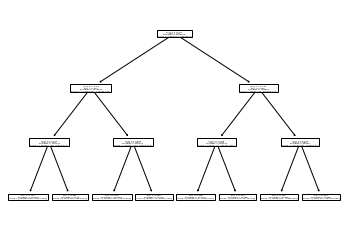

In [46]:
plot_tree(dt_pipe.best_estimator_.named_steps['clf'])

In [48]:
plot_decision_tree(dt_pipe.best_estimator_.named_steps['clf'], feature_cols, ['seized','cleared'])

NameError: name 'graphviz' is not defined

In [34]:
rf_pipe_2.best_estimator_

Pipeline(steps=[('targetEncoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['species_code',
                                                   'wildlf_desc', 'wildlf_cat',
                                                   'ctry_org', 'ctry_ie',
                                                   'purp', 'src', 'trans_mode',
                                                   'pt_cd',
                                                   'ship_date_mm'])])),
                ('standardScaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        n_estimators=50, random_state=42))])